#프로젝트 주제: 한국어 네이버 영화리뷰 감정분석  
#데이터: Naver sentiment movie corpus

# 1. 데이터 준비

In [ ]:
!pip install gensim==4.3.2

In [ ]:
!pip install scipy==1.12.0 numpy==1.26.3

In [ ]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

In [2]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.2.2
0.6.0
4.3.2


In [3]:
import pandas as pd

train_data = pd.read_table("/content/ratings_train.txt")
test_data = pd.read_table("/content/ratings_test.txt")

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 뒤에서 4개의 특수 토큰을 위한 공간을 확보하기 위해 -4

    # <PAD>=0, <UNK>=1, <BOS>=2, <EOS>=3 순서로 지정하고,
    # 그 뒤에 빈도수 상위 9,996개의 단어를 순서대로 추가
    vocab = ['<PAD>', '<UNK>', '<BOS>', '<EOS>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}  # 단어를 key로, 인덱스를 value로 갖는 사전을 만든다.

    # OOV 단어를 <UNK>의 인덱스(1)로 매핑
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    # <PAD>, <UNK> 인덱스 확인
    print(f"PAD 인덱스: {word_to_index['<PAD>']}")
    print(f"UNK 인덱스: {word_to_index['<UNK>']}")

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

PAD 인덱스: 0
UNK 인덱스: 1


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리, tokenizer와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index, tokenizer): # 형태소 토큰화를 위해 tokenizer도 인자로 받기
    # split에서 morphs 형태소 토큰화로 수정
    tokens = tokenizer.morphs(sentence)
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in tokens]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index, tokenizer):
    return [get_encoded_sentence(sentence, word_to_index, tokenizer) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- torch.nn.utils.rnn.pad_sequence 을 활용한 패딩 추가

## 3.1. 적절한 최대 문장 길이를 지정하기 위해 데이터셋 문장 길이의 분포 확인

문장 길이 최대: 116
문장 길이 95% 분위수: 47.00


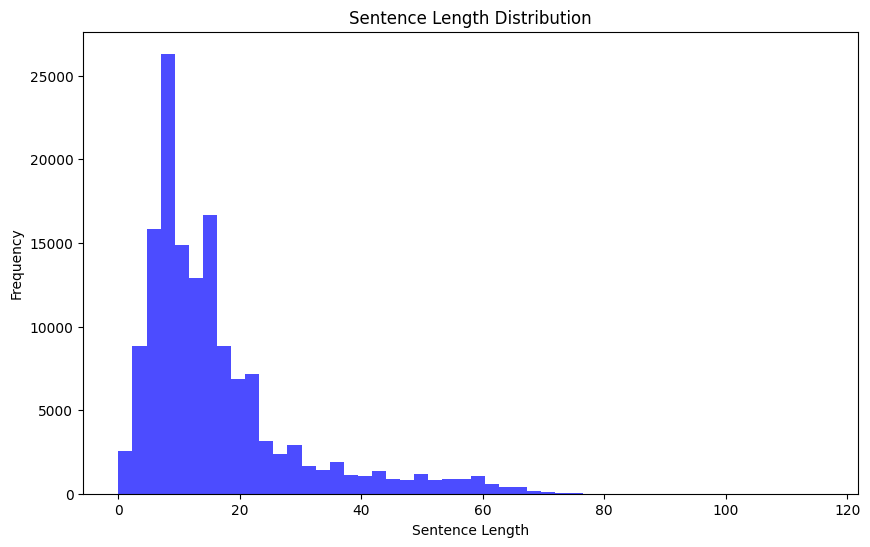

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 문장 길이 리스트 생성
train_lengths = [len(sentence) for sentence in X_train]

# 2. 통계치 확인
print(f"문장 길이 최대: {np.max(train_lengths)}")
print(f"문장 길이 95% 분위수: {np.percentile(train_lengths, 95):.2f}")

# 3. 시각화 (히스토그램)
plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, color='blue')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

## 3.2. 적절한 최대 문장 길이 지정
최대 문장 길이가 너무 길면?  
- padding으로 채워지는 짧은 문장들이 너무 많아지게 되고, 비효율적이다.  

최대 문장 길이가 너무 짧으면?  
- 긴 문장의 정보를 잃는다.  

따라서 위에서 구한 95% 분위수 47로 결정한다.

In [8]:
max_len = 47

## 3.3. torch.nn.utils.rnn.pad_sequence 을 활용한 패딩 추가
한 값을 정해서 전체 데이터를 패딩하는 정적 패딩이 아닌, 배치를 나눠서 패딩하는 동적 패딩을 한다.  

1. 일단 모든 문장의 길이를 47 이내로 자른다.
2. 모든 문장 길이가 47인 상태로 배치를 나눈다.
3. 만약 특정 배치 내의 문장의 최대 길이가 47이라면 47을 최대로 잡고 패딩하고,
4. 최대 길이가 30이라면 30을 최대로 잡고 패딩하는 방식  

이렇게 하면 계산 효율이 좋아진다.


In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# 1. PyTorch Dataset 클래스 정의
# (X_train, y_train을 묶어주는 역할)
class NsmcDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # 데이터를 파이썬 리스트 상태로 반환
        return self.sequences[idx], self.labels[idx]

# 2. collate_fn (배치 처리 함수) 정의
def collate_fn(batch):
    text_list, label_list = [], []

    for (_text, _label) in batch:
        label_list.append(_label)

        # 1. 자르기
        # max_len (47)보다 긴 문장은 뒷부분을 자른다.
        truncated_text = _text[ :max_len]
        text_list.append(torch.tensor(truncated_text, dtype=torch.int64))

    # 2. Dynamic Padding (동적 패딩)
    # 64개(배치 크기)의 텐서 리스트를 받아,
    # 이 배치에서 가장 긴 문장을 기준으로 <PAD> 토큰(0)을 채운다.
    padded_texts = pad_sequence(text_list,
                                batch_first=True,
                                padding_value=0)

    labels = torch.tensor(label_list, dtype=torch.int64)
    return padded_texts, labels

# 3. DataLoader 생성
batch_size = 64

train_dataset = NsmcDataset(X_train, y_train)
test_dataset = NsmcDataset(X_test, y_test)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          # 배치로 묶는 커스텀 함수를 입력하터 collate_fn에 위의 함수 입력
                          collate_fn=collate_fn,
                          num_workers=4,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=collate_fn)

# 4. (확인용) 잘 작동하는지 첫 번째 배치를 출력
print("--- 동적 패딩 확인 (첫 번째 배치) ---")
for texts, labels in train_loader:
    print("Texts shape:", texts.shape)
    print("Labels shape:", labels.shape)
    print("첫 번째 문장 (패딩됨):", texts[0])
    break

--- 동적 패딩 확인 (첫 번째 배치) ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Texts shape: torch.Size([64, 47])
Labels shape: torch.Size([64])
첫 번째 문장 (패딩됨): tensor([ 492,  163,   51,   27,  116,    1,   66,  122, 7625,    6,  131, 7540,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])


# 4. 모델 구성 및 validation set 구성

## 4.1. validation set 구성

In [38]:
from torch.utils.data import random_split

# 1. 훈련/검증 데이터셋 비율 8:2.
total_train_size = len(train_dataset)
valid_size = int(total_train_size * 0.2)
train_size = total_train_size - valid_size

# 2. random_split으로 데이터셋을 분리한다.
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

print(f"총 훈련 데이터: {total_train_size}개")
print(f"분리된 훈련 데이터: {len(train_subset)}개")
print(f"분리된 검증 데이터: {len(valid_subset)}개")

# 4. 새로운 DataLoader를 생성. (collate_fn은 동일하게 사용)
batch_size = 64

train_loader = DataLoader(train_subset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn,
                          num_workers=4,
                          pin_memory=True)

valid_loader = DataLoader(valid_subset,
                          batch_size=batch_size,
                          shuffle=False, # 검증 데이터는 섞을 필요 없음
                          collate_fn=collate_fn,
                          num_workers=4,
                          pin_memory=True)

총 훈련 데이터: 146182개
분리된 훈련 데이터: 116946개
분리된 검증 데이터: 29236개


## 4.2. 모델 구성

In [39]:
# 모델을 비교하기 위해서는 동일한 파라미터를 사용해야 함
import torch.nn as nn
import torch.nn.functional as F

# 공통 하이퍼파라미터 정의
VOCAB_SIZE = len(word_to_index)    # 단어 사전의 크기
EMBEDDING_DIM = 100                # 임베딩 벡터의 차원
HIDDEN_DIM = 128                   # RNN/LSTM의 은닉 상태 차원
OUTPUT_DIM = 1                     # 출력 차원 (긍정=1, 부정=0 -> 1개)
N_LAYERS = 2                       # RNN/LSTM 레이어 개수
BIDIRECTIONAL = True               # 양방향 RNN/LSTM 여부
DROPOUT_RATE = 0.5                 # 드롭아웃 비율
PAD_IDX = 0                        # 패딩 인덱스 (0)

### 4.2.1. 기본 RNN

In [40]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        super().__init__()

        # 1. 임베딩 레이어
        # padding_idx: PAD 토큰은 학습 중에 무시하도록 설정
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # 2. RNN 레이어
        self.rnn = nn.RNN(input_size=embedding_dim,
                          hidden_size=hidden_dim,
                          num_layers=n_layers,
                          bidirectional=bidirectional,
                          batch_first=True,
                          dropout=dropout)

        # 3. FC 레이어
        fc_input_dim = hidden_dim * 2  # 양방향이므로
        self.fc = nn.Linear(fc_input_dim, output_dim)

        # 4. 드롭아웃
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        # 1. 임베딩
        embedded = self.embedding(text)

        # 2. RNN
        _output, hidden = self.rnn(embedded)

        # 3. 마지막 레이어의 은닉 상태 결합 (양방향 처리)
        if self.rnn.bidirectional:
            # (마지막 정방향, 마지막 역방향) 은닉 상태를 결합
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        # 4. FC 레이어 통과
        prediction = self.fc(hidden)

        return prediction.squeeze(1)

### 4.2.2. LSTM

In [41]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        super().__init__()

        # 1. 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # 2. LSTM 레이어
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           batch_first=True,
                           dropout=dropout)

        # 3. FC 레이어
        fc_input_dim = hidden_dim * 2
        self.fc = nn.Linear(fc_input_dim, output_dim)

        # 4. 드롭아웃
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        embedded = self.embedding(text)

        # 2. LSTM
        _output, (hidden, cell) = self.lstm(embedded)

        # 3. 마지막 레이어의 은닉 상태 결합 (양방향 처리)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        # 4. FC 레이어 통과
        prediction = self.fc(hidden)

        return prediction.squeeze(1)

### 4.2.3. 1D CNN

In [42]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):
        super().__init__()

        # 1. 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # 2. 1D Convolution 레이어들 (다른 커널 크기를 사용)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=n_filters,
                      kernel_size=k) # n-gram 크기
            for k in filter_sizes
        ])

        # 3. FC 레이어
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        # 4. 드롭아웃
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        # 1. 임베딩
        embedded = self.embedding(text)

        # 2. Conv1d를 위한 차원 변경
        embedded = embedded.permute(0, 2, 1)

        # 3. Convolution + ReLU + Max Pooling
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # 4. 모든 풀링 결과를 결합
        cat = self.dropout(torch.cat(pooled, dim=1))

        # 5. FC 레이어 통과
        prediction = self.fc(cat)

        return prediction.squeeze(1)

# 5. 모델 훈련

## 5.1. 함수 정의

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

# 0. GPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. 헬퍼 함수 정의
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# 2. 훈련 함수 정의
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for texts, labels in iterator:
        texts = texts.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        # 실험 결과 기울기 폭주 발생
        # 그러므로 기울기의 최대 크기를 1.0으로 제한
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 3. 평가 함수 정의
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            labels = labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Using device: cuda


## 5.2. 기본 RNN 모델 학습

In [44]:
model_rnn = RNNModel(VOCAB_SIZE,
                     EMBEDDING_DIM,
                     HIDDEN_DIM,
                     OUTPUT_DIM,
                     N_LAYERS,
                     BIDIRECTIONAL,
                     DROPOUT_RATE,
                     PAD_IDX)

# 옵티마이저 및 손실 함수
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

# device로 이동
model_rnn = model_rnn.to(device)
criterion = criterion.to(device)

# epoch별 결과를 저장할 빈 리스트 생성
train_losses_RNN = []
train_accs_RNN = []
valid_losses_RNN = []
valid_accs_RNN = []

print("\n--- RNN Model Training Start ---")

for epoch in range(10):
    train_loss, train_acc = train(model_rnn, train_loader, optimizer_rnn, criterion)
    valid_loss, valid_acc = evaluate(model_rnn, valid_loader, criterion)

    train_losses_RNN.append(train_loss)
    train_accs_RNN.append(train_acc)
    valid_losses_RNN.append(valid_loss)
    valid_accs_RNN.append(valid_acc)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

print("--- RNN Model Training Finished ---")


--- RNN Model Training Start ---
Epoch: 01
	Train Loss: 0.624
	 Val. Loss: 0.582
Epoch: 02
	Train Loss: 0.540
	 Val. Loss: 0.541
Epoch: 03
	Train Loss: 0.498
	 Val. Loss: 0.501
Epoch: 04
	Train Loss: 0.463
	 Val. Loss: 0.494
Epoch: 05
	Train Loss: 0.437
	 Val. Loss: 0.445
Epoch: 06
	Train Loss: 0.415
	 Val. Loss: 0.418
Epoch: 07
	Train Loss: 0.398
	 Val. Loss: 0.431
Epoch: 08
	Train Loss: 0.385
	 Val. Loss: 0.427
Epoch: 09
	Train Loss: 0.372
	 Val. Loss: 0.393
Epoch: 10
	Train Loss: 0.361
	 Val. Loss: 0.397
--- RNN Model Training Finished ---


## 5.3. LSTM 모델 학습

In [45]:
model_lstm = LSTMModel(VOCAB_SIZE,
                        EMBEDDING_DIM,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT_RATE,
                        PAD_IDX)

# 옵티마이저 및 손실 함수
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

# device로 이동
model_lstm = model_lstm.to(device)
criterion = criterion.to(device)

# epoch별 결과를 저장할 빈 리스트 생성
train_losses_LSTM = []
train_accs_LSTM = []
valid_losses_LSTM = []
valid_accs_LSTM = []

print("\n--- LSTM Model Training Start ---")

for epoch in range(10):
    train_loss, train_acc = train(model_lstm, train_loader, optimizer_lstm, criterion)
    valid_loss, valid_acc = evaluate(model_lstm, valid_loader, criterion)

    train_losses_LSTM.append(train_loss)
    train_accs_LSTM.append(train_acc)
    valid_losses_LSTM.append(valid_loss)
    valid_accs_LSTM.append(valid_acc)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

print("--- LSTM Model Training Finished ---")


--- LSTM Model Training Start ---
Epoch: 01
	Train Loss: 0.530
	 Val. Loss: 0.438
Epoch: 02
	Train Loss: 0.410
	 Val. Loss: 0.397
Epoch: 03
	Train Loss: 0.377
	 Val. Loss: 0.379
Epoch: 04
	Train Loss: 0.355
	 Val. Loss: 0.370
Epoch: 05
	Train Loss: 0.338
	 Val. Loss: 0.374
Epoch: 06
	Train Loss: 0.323
	 Val. Loss: 0.374
Epoch: 07
	Train Loss: 0.310
	 Val. Loss: 0.357
Epoch: 08
	Train Loss: 0.298
	 Val. Loss: 0.359
Epoch: 09
	Train Loss: 0.287
	 Val. Loss: 0.358
Epoch: 10
	Train Loss: 0.277
	 Val. Loss: 0.396
--- LSTM Model Training Finished ---


## 5.4. 1D CNN 모델 학습

In [46]:
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]

model_cnn = CNNModel(VOCAB_SIZE,
                     EMBEDDING_DIM,
                     N_FILTERS,
                     FILTER_SIZES,
                     OUTPUT_DIM,
                     DROPOUT_RATE,
                     PAD_IDX)

# 옵티마이저 및 손실 함수
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

# device로 이동
model_cnn = model_cnn.to(device)
criterion = criterion.to(device)

# epoch별 결과를 저장할 빈 리스트 생성
train_losses_CNN = []
train_accs_CNN = []
valid_losses_CNN = []
valid_accs_CNN = []

print("\n--- CNN Model Training Start ---")

for epoch in range(30):
    train_loss, train_acc = train(model_cnn, train_loader, optimizer_cnn, criterion)
    valid_loss, valid_acc = evaluate(model_cnn, valid_loader, criterion)

    train_losses_CNN.append(train_loss)
    train_accs_CNN.append(train_acc)
    valid_losses_CNN.append(valid_loss)
    valid_accs_CNN.append(valid_acc)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

print("--- CNN Model Training Finished ---")


--- CNN Model Training Start ---
Epoch: 01
	Train Loss: 0.610
	 Val. Loss: 0.520
Epoch: 02
	Train Loss: 0.512
	 Val. Loss: 0.465
Epoch: 03
	Train Loss: 0.464
	 Val. Loss: 0.433
Epoch: 04
	Train Loss: 0.434
	 Val. Loss: 0.413
Epoch: 05
	Train Loss: 0.411
	 Val. Loss: 0.398
Epoch: 06
	Train Loss: 0.393
	 Val. Loss: 0.388
Epoch: 07
	Train Loss: 0.378
	 Val. Loss: 0.379
Epoch: 08
	Train Loss: 0.365
	 Val. Loss: 0.372
Epoch: 09
	Train Loss: 0.353
	 Val. Loss: 0.367
Epoch: 10
	Train Loss: 0.342
	 Val. Loss: 0.363


KeyboardInterrupt: 

1차 시도  
- 30 epoch를 했는데, 6 epoch 부터 기울기 폭주 발생 (validation loss가 0.8이 넘었음)
- 그래서 train 함수에 최대 기울기를 1로 지정하고 10 epoch로 다시 학습해봄  

2차 시도
- lstm의 경우 10 에폭에서 loss가 0.5까지 갔음
- 이번엔 lr=0.0001로 해서 다시 시도  

3차 시도
- lr을 낮췄더니 lstm 10 에폭에서 0.3 중반 loss가 나옴. 효과가 있었음. (1dcnn도 마찬가지)  

# 6. Loss, Accuracy 그래프 시각화

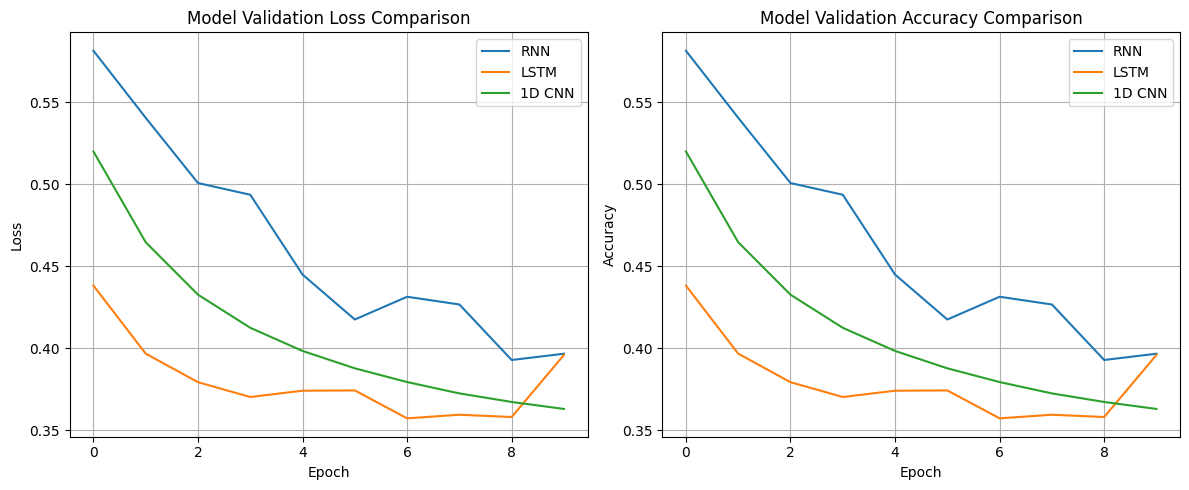

In [47]:
import matplotlib.pyplot as plt

# 1. 그래프 크기 설정
plt.figure(figsize=(12, 5))

# 2. Validation Loss 비교 그래프
plt.subplot(1, 2, 1)
plt.plot(valid_losses_RNN, label='RNN')
plt.plot(valid_losses_LSTM, label='LSTM')
plt.plot(valid_losses_CNN, label='1D CNN')
plt.title('Model Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Validation Accuracy 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(valid_losses_RNN, label='RNN')
plt.plot(valid_losses_LSTM, label='LSTM')
plt.plot(valid_losses_CNN, label='1D CNN')
plt.title('Model Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 4. 그래프 출력
plt.tight_layout() # 그래프 간격 자동 조절
plt.show()

RNN, LSTM 모델은 8 에폭부터 loss가 증가하는 모습.  
반면 1D CNN 모델은 안정적으로 계속 감소하는 모습이다.

# 7. 정확도 측정

In [50]:
# --- 1. RNN 모델 정확도 측정 ---
model_rnn = model_rnn.to(device)

# evaluate 함수로 테스트셋 평가
test_loss_rnn, test_acc_rnn = evaluate(model_rnn, test_loader, criterion)

print(f"--- RNN Model Test Results ---")
print(f'\tTest Loss: {test_loss_rnn:.3f}')
print(f'\tTest Acc:  {test_acc_rnn*100:.2f}%')


# --- 2. LSTM 모델 정확도 측정 ---
model_lstm = model_lstm.to(device)

test_loss_lstm, test_acc_lstm = evaluate(model_lstm, test_loader, criterion)

print(f"\n--- LSTM Model Test Results ---")
print(f'\tTest Loss: {test_loss_lstm:.3f}')
print(f'\tTest Acc:  {test_acc_lstm*100:.2f}%')


# --- 3. 1D CNN 모델 정확도 측정 ---

model_cnn = model_cnn.to(device)

test_loss_cnn, test_acc_cnn = evaluate(model_cnn, test_loader, criterion)

print(f"\n--- 1D CNN Model Test Results ---")
print(f'\tTest Loss: {test_loss_cnn:.3f}')
print(f'\tTest Acc:  {test_acc_cnn*100:.2f}%')

--- RNN Model Test Results ---
	Test Loss: 0.400
	Test Acc:  82.92%

--- LSTM Model Test Results ---
	Test Loss: 0.399
	Test Acc:  84.33%

--- 1D CNN Model Test Results ---
	Test Loss: 0.366
	Test Acc:  83.76%


아쉽게도 LSTM 모델 정확도 84% 나왔습니다,,,  
주말에 Word2Vec 써서 성능 올려보겠습니다,,,,,